# Background
The dataset contains 21,152 statements that are fact checked by experts collected from a popular fact check website PolitiFact. There are also sources of statement contained in dataset. Facing such a large amount of misinformation on social media, it is challenging to distinguish the fake news. It would be interesting to try to find linguistic patterns in false political statement. Also, there may be patterns lying under sources , statement date and statement originators of those fake news.
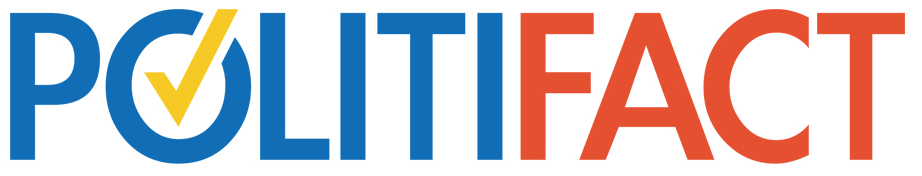

- Task (Binary text classification): Train a classifier for distinguishing fake political statements. 

- Data Source: https://www.kaggle.com/datasets/rmisra/politifact-fact-check-dataset

- Models: Naive Bayes classifier, Random forest and XGBoost


# Import Libraries

In [702]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from transformers import pipeline
from transformers import TFBertModel, BertTokenizer
from xgboost import XGBClassifier
import tensorflow as tf
import text2emotion as te
from textblob import TextBlob
#pd.set_option('mode.chained_assignment', None)
import warnings
warnings.filterwarnings('ignore')

# Data Exploration
 - Data Source: https://www.kaggle.com/datasets/rmisra/politifact-fact-check-dataset
 - Data Description:
   - verdict (categorical): The verdict of fact check in one of 6 categories {true, mostly-true, half-true, mostly-false, false, and pants-fire}
   - statement (text): statement being fact checked
   - statement_source (categorical): the source where the statement was made. It is one of 13 categories: {speech,television,news,blog,social_media,advertisement,campaign,meeting,radio,email,testimony,statement,other}

### Load the Data

In [2]:
# Load data from json file
df = pd.read_json('politifact_factcheck_data.json', lines=True)
df_data = df[['verdict', 'statement', 'statement_source']]

# Display samples of data
df_data.head()

,verdict,statement,statement_source
0,true,John McCain opposed bankruptcy protections for...,speech
1,false,"""Bennie Thompson actively cheer-led riots in t...",television
2,mostly-true,"Says Maggie Hassan was ""out of state on 30 day...",news
3,false,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",blog
4,half-true,"""I'm the only (Republican) candidate that has ...",television


In [3]:
# Show samples of statements
pd.set_option('display.max_colwidth', None)
df_data['statement'].head(5)

0    John McCain opposed bankruptcy protections for families "who were only in bankruptcy because of medical expenses they couldn't pay."
1                                                                                 "Bennie Thompson actively cheer-led riots in the ’90s."
2                                                            Says Maggie Hassan was "out of state on 30 days over the last three months."
3                                                                  "BUSTED: CDC Inflated COVID Numbers, Accused of Violating Federal Law"
4                                                 "I'm the only (Republican) candidate that has actually reduced the size of government."
Name: statement, dtype: object

In [12]:
# convert columns to proper types
df_data["statement"] = df_data["statement"].astype('str')
df_data["statement_source"] = df_data["statement_source"].astype('category')

In [13]:
# Column Information
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   verdict           21152 non-null  object  
 1   statement         21152 non-null  object  
 2   statement_source  21152 non-null  category
dtypes: category(1), object(2)
memory usage: 351.9+ KB


### Initial Exploration
 - Number of samples 
 - Check null value
 - Convert target value into binary classification
 - Number of samples in each classes after conversion

In [14]:
# Number of samples: 21152
df_data.shape

(21152, 3)

In [15]:
# Check null value
df_data.isnull().sum() 

verdict             0
statement           0
statement_source    0
dtype: int64

In [31]:
# Check number of samples in each classes in 'verdict'
Counter(df_data['verdict'])

Counter({'true': 2463,
         'false': 5625,
         'mostly-true': 3332,
         'half-true': 3597,
         'pants-fire': 2703,
         'mostly-false': 3432})

Convert target value to a binary classification label

In [18]:
# Convert target value to a binary classification label
# Convert half-true, false, barely-true and pants-fire labels to False
# Convert the remaining labels to True
dict_map = {'true':1,
            'mostly-true':1,
            'half-true':1,
            'false':0,
            'pants-fire':0,
            'mostly-false':0}
df_data['label'] = df_data['verdict'].map(dict_map)
df_data[['verdict','label']].head(10)

,verdict,label
0,true,1
1,false,0
2,mostly-true,1
3,false,0
4,half-true,1
5,true,1
6,false,0
7,true,1
8,mostly-true,1
9,true,1


#### Number of Samples in Each Class:
9392 True samples and 11760 False samples, the data is balanced

In [22]:
# there are 9392 True samples and 11760 False samples
len(df_data[df_data['label'] == 1]), len(df_data[df_data['label'] == 0])

(9392, 11760)

<AxesSubplot:xlabel='count', ylabel='label'>

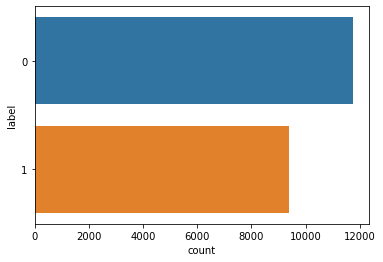

In [21]:
sns.countplot(y=df_data['label'],data = df_data)

the 'statement_source' column contains 13 unique ctegories

In [24]:
## Explore the statement_source
Counter(df_data['statement_source'])

Counter({'speech': 3310,
         'television': 603,
         'news': 5763,
         'blog': 1048,
         'other': 1063,
         'social_media': 4985,
         'advertisement': 1143,
         'campaign': 1230,
         'meeting': 293,
         'radio': 546,
         'email': 410,
         'testimony': 243,
         'statement': 515})

### Exploratory Data Analysis
 - Statement length
 - Word cloud of statement for each class
 - Statement source

**Average length of statement is 108**

In [26]:
## Length of Statement
df_data['statement_length'] = df_data['statement'].astype('str').apply(len)
df_data['statement_length'].describe()

count    21152.000000
mean       108.278650
std         46.238287
min         17.000000
25%         75.000000
50%        100.000000
75%        134.000000
max        446.000000
Name: statement_length, dtype: float64

**Compare the average statement length in two sample classes:**
true statement is slightly longer in average than false statement

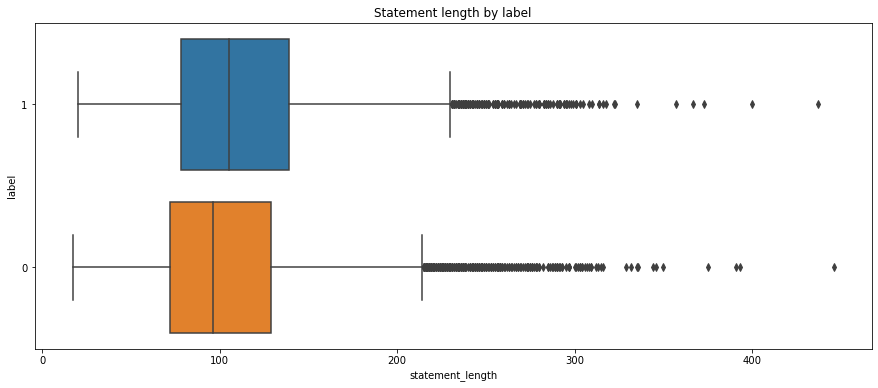

In [29]:
plt.figure(figsize=(15,6))
plt.title("Statement length by label")
df_data['label'] = df_data['label'].astype('str')
#sns.boxplot(y='verdict', x='statement_length', data=df_data)
sns.boxplot(y='label', x='statement_length', data=df_data)
df_data['label'] = df_data['label'].astype('int')

#### word cloud for two classes

In [687]:
#print(stopwords.words('english'))
# modify the stopwords according to the content
stopwords = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",\
                 "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he',\
                 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it',\
                 "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',\
                 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',\
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', \
                 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', \
                 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', \
                 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', \
                 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', \
                 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', \
                 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', \
                 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', \
                 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', \
                 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', \
                 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', \
                 "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', \
                 "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", \
                 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', \
                 "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "Says", \
                 "would","000"])


Some frequently mentioned words in true statements are: **state, tax, job, health**

<function matplotlib.pyplot.show(close=None, block=None)>

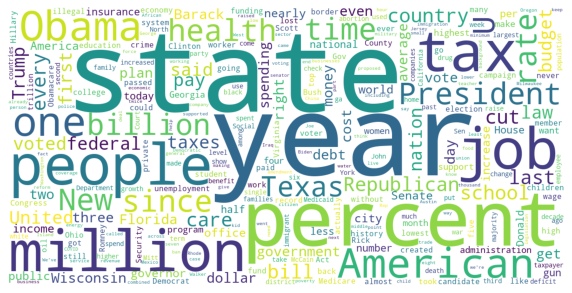

In [33]:
text = " ".join(i for i in df_data[df_data['label'] == 1].statement)
wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1,
               stopwords = stopwords)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

Some frequently mentioned words in false statements are: **state, president, names of presidents, covid, health care**

<function matplotlib.pyplot.show(close=None, block=None)>

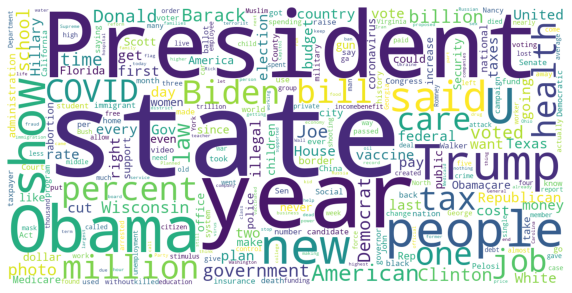

In [34]:
text = " ".join(i for i in df_data[df_data['label'] == 0].statement)

wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1,
               stopwords = stopwords)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

#### Are there Sources that are more reliable or unreliable than the others?
social_media and blog are two sources from which the statements are most likely to be fake news. For other catogory of sources, the proportion of fake and real news are even. 

<AxesSubplot:title={'center':'Distribution of statement_source by verdict'}, xlabel='count', ylabel='statement_source'>

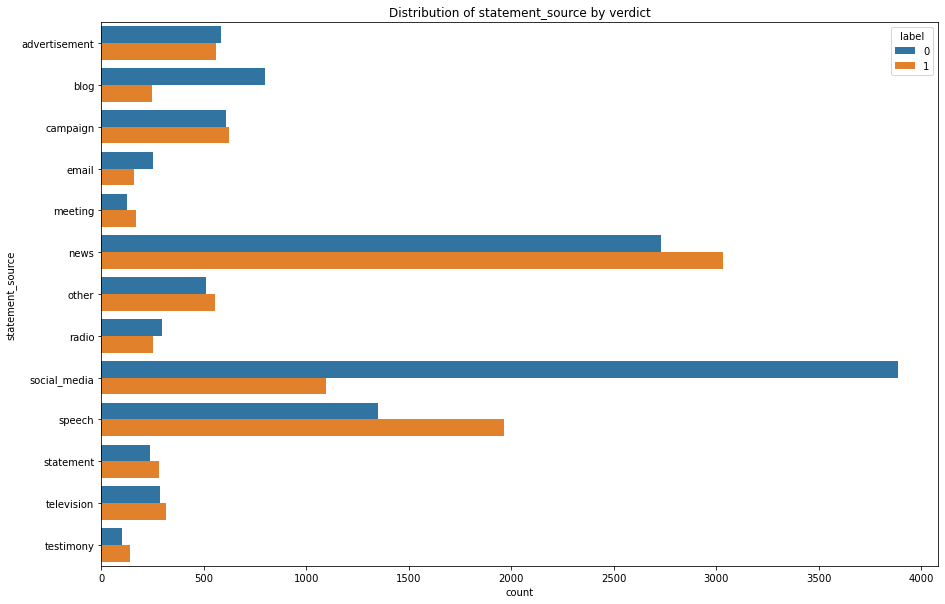

In [35]:
plt.figure(figsize=(15,10))

plt.title("Distribution of statement_source by verdict")

sns.countplot(data=df_data, y="statement_source", hue="label")

# Data Preprocessing
 - Text cleaning on 'statement' colomn
 - Extend Additional Features
 - Scaling on numerical data
 - One hot encoding on categorical data
 - Using Tf-idf to convert text data

### Text cleaning

In [695]:
# look at the 'statement' from the first several samples
df_data.iloc[0:5]['statement']

0    John McCain opposed bankruptcy protections for families "who were only in bankruptcy because of medical expenses they couldn't pay."
1                                                                                 "Bennie Thompson actively cheer-led riots in the ’90s."
2                                                            Says Maggie Hassan was "out of state on 30 days over the last three months."
3                                                                  "BUSTED: CDC Inflated COVID Numbers, Accused of Violating Federal Law"
4                                                 "I'm the only (Republican) candidate that has actually reduced the size of government."
Name: statement, dtype: object

Steps of text cleaning:
- Replace contractions with their full forms (e.g. "n't" becomes "not").
- Remove the word "Says" at the beginning of the sentences.
- Remove the quotation marks at the beginning and end of the sentences.
- Remove all punctuation marks.
- Tokenize the text into individual words.
- Lemmatize each word using WordNetLemmatizer.
- Join the cleaned tokens back into a string.

In [677]:
def text_clean(text):
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text) # prime 
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # remove the word 'Says' at the beginning of the sentences
    text = re.sub(r'^Says\s', '', text)
    # remove the quotation mark at the beginning and the end of the sentences
    if re.match(r'^".*"$', text):
        text = text[1:-1]
    # Remove all punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text into individual words
    tokens = word_tokenize(text)

    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize each word and join them back into a string
    cleaned_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    cleaned_text = " ".join(cleaned_tokens)

    return text

In [678]:
# create a column with cleaned statement
df_data['clean_statement'] = df_data['statement'].apply(text_clean)

take a look at a comparison of cleaned statement and original statement

In [683]:
df_data['clean_statement'] = df_data['clean_statement'].astype('str')
df_data[['clean_statement','statement']]

,clean_statement,statement
0,John McCain opposed bankruptcy protections for families who were only in bankruptcy because of medical expenses they could not pay,"John McCain opposed bankruptcy protections for families ""who were only in bankruptcy because of medical expenses they couldn't pay."""
1,Bennie Thompson actively cheerled riots in the 90s,"""Bennie Thompson actively cheer-led riots in the ’90s."""
2,Maggie Hassan was out of state on 30 days over the last three months,"Says Maggie Hassan was ""out of state on 30 days over the last three months."""
3,BUSTED CDC Inflated COVID Numbers Accused of Violating Federal Law,"""BUSTED: CDC Inflated COVID Numbers, Accused of Violating Federal Law"""
4,I am the only Republican candidate that has actually reduced the size of government,"""I'm the only (Republican) candidate that has actually reduced the size of government."""
...,...,...
21147,the large trade deficit with Japan stems from them sending millions of cars while we send them wheat but the deficit is changing rapidly,"Says the large trade deficit with Japan stems from them sending ""millions of cars,"" while ""we send them wheat,"" but the deficit is ""changing rapidly."""
21148,Tens of thousands of people leave New York every week,"""Tens of thousands"" of people leave New York every week."
21149,I have fought for our shared values without being an ideologue or a partisan,"""I have fought for our shared values without being an ideologue or a partisan"""
21150,Germany halts all Covid19 vaccines says they are unsafe and no longer recommended,"""Germany halts all Covid-19 vaccines, says they are unsafe and no longer recommended!!"""


### Feature Engineering
 - Apply OneHotEncoder() to encode Categorical column: 'statement_source'
 - Apply MinMaxScaler() to scale Numerical column: 'text_length'
 - Apply TfidfVecterizer() to convert Text column: 'statement'

#### Build a ColumnTransformer for future pipeline in modeling part
As I'm going to use RandomizedSearchCV for parameter tuing in modeling part, using ColumnTransformer() can help transfer all columns in dataframe in one step in pipeline
- **NumericalScaler**: applies the MinMaxScaler transformation to the statement_length column. This scaler scales the values in the column to a range between 0 and 1, which can be helpful for some machine learning algorithms.
- **CategoricalEncoder**: applies the OneHotEncoder transformation to the statement_source column. This encoder converts each unique value in the column into a binary feature, which can be useful for models that expect categorical data.
- **TextVecterizer**: applies the TfidfVectorizer transformation to the clean_statement column. This vectorizer converts each text document in the column into a vector of numerical features, based on the frequency of each word in the document. The resulting vectors can be used as input to machine learning algorithms.
- **remainder='passthrough'**: any columns not specified in the transformers list should be left unchanged. 

In [691]:
## define names of different type columns
cat_cols = ['statement_source']
num_cols = ['statement_length']
text_cols = 'clean_statement'

encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler(feature_range=(0,1))
vecterizer = TfidfVectorizer(stop_words=stopwords, max_df=0.8, min_df=5, ngram_range=(1,1))

## Construct ColumnTransformer()
preprocessor = ColumnTransformer(
    transformers = [
        ('NumericalScaler', scaler, num_cols),
        ('CategoricalEncoder', encoder, cat_cols),
        ('TextVecterizer', vecterizer, text_cols)
    ],
    remainder='passthrough'
)

look at the transformed columns after ColumnTransformer(), check if the preprocessor works properly

In [692]:
## build dataframe for features and label
X_features = df_data[['statement_length', 'statement_source', 'clean_statement']]
Y = df_data[['label']]

In [694]:
## fit_transform 
X_transformed = preprocessor.fit_transform(X_features).toarray()

## get the column names after fitting
column_names = ( 
    preprocessor.named_transformers_["NumericalScaler"].get_feature_names_out().tolist()
    + preprocessor.named_transformers_["CategoricalEncoder"].get_feature_names_out().tolist()
    + preprocessor.named_transformers_["TextVecterizer"].get_feature_names_out().tolist()
)

## construct a dataframe to see the transformed result
transformed = pd.DataFrame(X_transformed, columns=column_names)
transformed

,statement_length,statement_source_advertisement,statement_source_blog,statement_source_campaign,statement_source_email,statement_source_meeting,statement_source_news,statement_source_other,statement_source_radio,statement_source_social_media,...,youth,youtube,youve,zealand,zero,zika,zip,zone,zones,zuckerberg
0,0.268065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.088578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.137529,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.123543,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.163170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,0.310023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21148,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21149,0.142191,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21150,0.163170,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test Split
- split all samples in train and test set (train:test = 8:2)

In [76]:
X_train, X_test, y_train, y_test = \
train_test_split(X_features, Y, test_size=0.2)

16921 samples in train set and 4231 samples in test set

In [77]:
X_train.shape, X_test.shape

((16921, 3), (4231, 3))

# Modeling
In the modeling part, three classifier models are used:
 - **Naive Bayes**: Naive Bayes classifier is a probabilistic algorithm for text classification that uses Bayes' theorem to calculate the probability of a document belonging to a certain class based on the frequencies of the words in the document. It assumes that the features in the document are independent of each other.
 - **Random Forest**: Random Forest classifier is an ensemble learning algorithm that combines multiple decision trees to make predictions for text classification tasks. It works by aggregating the predictions of multiple individual trees and selecting the most frequent prediction as the final output. 
 - **XGBoost**:XGBoost classifier is an advanced gradient boosting algorithm that uses a combination of decision trees and gradient boosting to improve the accuracy and efficiency of text classification models. It works by optimizing a loss function and iteratively adding new trees to the ensemble, while using regularization to prevent overfitting and improve generalization performance. 

## Naive Bayes Classifier
P(a|x) ~ SUM_i log(x_i | a) + log P(a)
 - Build Pipeline
 - Parameter Tuning
   - Choose parameters for tuning
   - Use RandomizedSearchCV()
 - Model Evaluation
   - Accuracy Score
   - Classification Report
   - Confusion Matrix
   - ROC curve
 - Explanation on Model Performance
   - Top Predictive Features
   - Error Analyais

#### Naive Bayes - build pipeline

In [534]:
pipeline_NB = Pipeline([
    ("Preprocessor", preprocessor),
    ('Classifier', MultinomialNB()), 
])

print out all the parameters i can tune in the pipeline

In [535]:
pipeline_NB.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Preprocessor', 'Classifier', 'Preprocessor__n_jobs', 'Preprocessor__remainder', 'Preprocessor__sparse_threshold', 'Preprocessor__transformer_weights', 'Preprocessor__transformers', 'Preprocessor__verbose', 'Preprocessor__verbose_feature_names_out', 'Preprocessor__NumericalScaler', 'Preprocessor__CategoricalEncoder', 'Preprocessor__TextVecterizer', 'Preprocessor__NumericalScaler__clip', 'Preprocessor__NumericalScaler__copy', 'Preprocessor__NumericalScaler__feature_range', 'Preprocessor__CategoricalEncoder__categories', 'Preprocessor__CategoricalEncoder__drop', 'Preprocessor__CategoricalEncoder__dtype', 'Preprocessor__CategoricalEncoder__handle_unknown', 'Preprocessor__CategoricalEncoder__sparse', 'Preprocessor__TextVecterizer__analyzer', 'Preprocessor__TextVecterizer__binary', 'Preprocessor__TextVecterizer__decode_error', 'Preprocessor__TextVecterizer__dtype', 'Preprocessor__TextVecterizer__encoding', 'Preprocessor__TextVecterizer__input', 'Prep

**Naive Bayes - Parameters choosen for tuning**
 - TfidfVectorizer():
   - max_df: the maximum document frequency of words to be included in the vocabulary. Setting this parameter too low may result in removing important words, while setting it too high may result in keeping irrelevant words. I choose values in [0.7, 0.8, 0.9].
   - min_df: the minimum document frequency of words to be included in the vocabulary. I choose values in [3, 5, 10].
   - ngram_range: the range of n-gram sizes to be used for feature extraction
 - MultinomialNB():
   - alpha: the Laplace smoothing parameter (0 indicating no smoothing)

In [537]:
# Define the parameter dist to search over
NB_param_dist = {
    'Preprocessor__TextVecterizer__max_df': [0.7, 0.8, 0.9],
    'Preprocessor__TextVecterizer__min_df': [3, 5, 10],
    'Preprocessor__TextVecterizer__ngram_range': [(1,1),(1,2),(2,2)],
    'Classifier__alpha': [0.1, 0.5, 1.0, 2.0]
}

#### Naive Bayes - Parameter Tuning: RandomizedSearchCV()

RandomizedSearchCV outperforms GridSearchCV when dataset is larger. It performs faster as the search is randomized and all the other parameters are held constant.

Set the scoring = 'f1', as the target value is f1 score

In [538]:
start = time.time()
random_search = RandomizedSearchCV(pipeline_NB, param_distributions=NB_param_dist, scoring = 'f1', random_state = 42)
random_search.fit(X_train, y_train)

end = time.time()
print(end-start) 

16.551769256591797


In [539]:
## print out the best parameters
print(random_search.best_params_)

{'Preprocessor__TextVecterizer__ngram_range': (1, 2), 'Preprocessor__TextVecterizer__min_df': 5, 'Preprocessor__TextVecterizer__max_df': 0.8, 'Classifier__alpha': 0.1}


According to the best parameters:
- In the vecterizer, max_df s set to 0.8, which means that any word that occurs in more than 80% of the documents will be excluded from the vocabulary. Min_df is set to 5, which means that any word that occurs less than 5 times in the corpus will be excluded from the vocabulary.
- In the classifier model, alpha is set to be 0.1, which means that a small amount of smoothing will be applied to the model's probabilities to avoid zero probability estimates. As the best performance is at alpha = 0.1, it indicates the original model has little overfitting as the number of sample is large

#### Naive Bayes - Model Validation
The RandomizedSearchCV() already performed 5-fold cross validation on data 

Here I use cross_val_score() to see the scores on each held-out data using best estimater

In [540]:
pipeline_NB_best = random_search.best_estimator_

In [541]:
scores = cross_val_score(pipeline_NB_best, X_train, y_train, cv=5, scoring='f1')
print(scores)

[0.65216    0.66500467 0.64562954 0.65443425 0.64717101]


#### Naive Bayes - Model evaluation on test data
After getting the best model, here I use different methods to evaluate the best model performance on test data:
accuracy score, classifiction report, confusion matrics, roc_auc

In [542]:
## fit the classifier on the training data
pipeline_NB_best.fit(X_train, y_train)

## make prediction on testing data
y_test_pred = pipeline_NB_best.predict(X_test)
y_test_pred

array([1, 0, 1, ..., 0, 0, 0])

- Accuracy score: 0.6681635547151974

In [545]:
NB_accuracy = accuracy_score(y_test, y_test_pred)
NB_accuracy

0.6681635547151974

- Classifiction report

In [546]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      2422
           1       0.60      0.68      0.64      1809

    accuracy                           0.67      4231
   macro avg       0.67      0.67      0.67      4231
weighted avg       0.68      0.67      0.67      4231



- Confusion Matrix

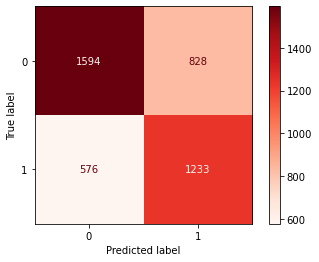

In [547]:
# Compute the confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline_NB_best, X_test, y_test, cmap = plt.cm.Reds)

- ROC curve

In [548]:
# Predict the class probabilities on the test set
y_test_pred_proba = pipeline_NB_best.predict_proba(X_test)[:, 1]
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
auc_score = roc_auc_score(y_test, y_test_pred_proba)
# Print the AUC score
print("AUC score:", auc_score)

AUC score: 0.7380219738083599


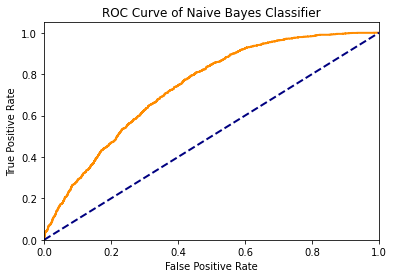

In [549]:
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of Naive Bayes Classifier")
plt.show()

#### Naive Bayes - Explanation on model performance
 - Get top distinguishing features for each class
 - Error analysis

In [632]:
print("Classes:", pipeline_NB_best.named_steps['Classifier'].classes_)

Classes: [0 1]


In [648]:
## get the vectorizer and classifier from the pipeline
vectorizer = pipeline_NB_best.named_steps['Preprocessor'].named_transformers_['TextVecterizer']
clf = pipeline_NB_best.named_steps['Classifier']
feature_names = vectorizer.get_feature_names()

**Get top distinguishing features for each class:**
 - calculate the difference of log probability of same word in two classes:
   > clf.feature_log_prob_[1][index] - clf.feature_log_prob_[0][index]

In [628]:
# calculate the difference of log probability of same word in two classes
diff_lst = []
for index, feature in enumerate(feature_names):
    ## calculate the difference of log_prob of same word in two classes
    diff = clf.feature_log_prob_[1][index] - clf.feature_log_prob_[0][index]
    diff_lst.append(diff)

**top 20 distinguishing words in true statements**

In [630]:
top_20_indices_positive = np.argsort(diff_lst)[::-1][:20]
df_distinguish_words_positive = pd.DataFrame({'feature':feature_names[top_20_indices_positive],
                                     '0_log_prob':clf.feature_log_prob_[0][top_20_indices_positive],
                                     '1_log_prob':clf.feature_log_prob_[1][top_20_indices_positive]                          
                                    })
df_distinguish_words_positive

,feature,0_log_prob,1_log_prob
0,mexico border,-12.91801,-8.651884
1,percent gdp,-12.91801,-8.769202
2,right,-12.91801,-8.867224
3,80,-12.91801,-8.908730
4,cuts wealthy,-12.91801,-9.184930
5,gallon gas,-12.91801,-9.194604
6,thing,-12.91801,-9.215544
7,pacific partnership,-12.91801,-9.217588
8,hire,-12.91801,-9.228169
9,website,-12.91801,-9.233827


**top 20 distinguishing words in false statements**

In [627]:
top_20_indices_negative = np.argsort(diff_lst)[:20]
df_distinguish_words_negative = pd.DataFrame({'feature':feature_names[top_20_indices_negative],
                                     '0_log_prob':clf.feature_log_prob_[0][top_20_indices_negative],
                                     '1_log_prob':clf.feature_log_prob_[1][top_20_indices_negative]                          
                                    })
df_distinguish_words_negative

,feature,0_log_prob,1_log_prob
0,photograph,-8.168053,-12.753975
1,southern,-8.352013,-12.753975
2,food stamps,-8.463328,-12.753975
3,get paid,-8.495305,-12.753975
4,public,-8.520491,-12.753975
5,get health,-8.577787,-12.753975
6,adding,-8.596086,-12.753975
7,rob portman,-8.674269,-12.753975
8,especially,-8.767442,-12.753975
9,immune,-8.770328,-12.753975


**error analysis**

In [587]:
error_index = np.where(y_test_pred != np.array(y_test['label']))[0]

In [590]:
error_samples = pd.concat([X_features.iloc[error_index], Y.iloc[error_index]], axis = 1)
error_samples.head(10)

,statement_length,statement_source,clean_statement,label
4,87,television,I am the only (Republican) candidate that has actually reduced the size of government.,1
5,76,news,There are actually only 30 countries that practice birthright citizenship.,1
7,135,news,"If you go strictly by the numbers, crime is down across the board. Last year we had a 10 percent decrease in the most serious crimes.",1
8,137,other,"The American people say, do not touch Social Security, do not touch Medicare, do not cut defense. That is 84 percent of the federal budget.",1
16,50,campaign,"Tampa Bay is ""leading the state in jobs creation.""",0
20,84,news,"Donald Trump ""literally has no plans to make higher education more affordable.""",1
23,87,speech,"During his governorship, Virginia made ""the largest investment ever in K-12 education.""",0
25,49,campaign,"he is ""cutting illegal immigration in half.""",0
29,55,television,"John Bolton ""fundamentally was a man of the left.""",0
31,58,speech,he lived in a colonia while working as a farm worker.,0


In [634]:
## extract some false negative samples
FN_samples = error_samples.iloc[:3]
FN_samples 

,statement_length,statement_source,clean_statement,label
4,87,television,I am the only (Republican) candidate that has actually reduced the size of government.,1
5,76,news,There are actually only 30 countries that practice birthright citizenship.,1
7,135,news,"If you go strictly by the numbers, crime is down across the board. Last year we had a 10 percent decrease in the most serious crimes.",1


In [653]:
for index, sample in FN_samples.iterrows():
    string = ""
    log_prob_0 = 0
    log_prob_1 = 0
    for word in sample['clean_statement'].split(" "):
        word = word.lower()
        string += word
        try:
            feat_idx = feature_names.index(word)
            string += '('+str(clf.feature_log_prob_[0][feat_idx]) + ','+str(clf.feature_log_prob_[1][feat_idx])+')'
            string += ' '
            log_prob_0 += clf.feature_log_prob_[0][feat_idx]
            log_prob_1 += clf.feature_log_prob_[1][feat_idx]
        except:
            string += ' '
    print("\n"+string)
    print(log_prob_0,log_prob_1)


i am the only (republican) candidate that has actually(-7.537057100408509,-7.302444589654776) reduced(-10.193379213019721,-9.83898229154857) the size(-9.815683249464332,-10.961686424207672) of government. 
-27.54611956289256 -28.103113305411014

there are actually(-7.537057100408509,-7.302444589654776) only 30(-10.946783544839336,-10.300612923814217) countries(-10.326989894801505,-9.791553642513122) that practice(-10.025744668843455,-10.150006174186629) birthright citizenship. 
-38.83657520889281 -37.54461733016875

if you go(-9.756654154239135,-9.018918099223058) strictly by the numbers, crime(-9.802208527846656,-12.753974721125413) is down across(-9.976923295622017,-9.967339423456462) the board. last(-9.42128612260533,-10.746057297427587) year(-8.728471863390391,-7.783468716279478) we had a 10(-4.167960379871961,-5.142627003721793) percent(-10.582127382205162,-10.240885742681224) decrease(-10.387666261987185,-9.242322136993868) in the most serious(-9.274586313853733,-9.9209661121148

From the error sample, Naive Bayes classifier tends to give low probability estimates for rare events, leading to a bias towards more frequent words in the training data. This can result in poor performance when dealing with rare or unseen words in the test data. 
For Naive Bayes, the result may largely depend on the training set

## Random Forest
 - Build Pipeline
 - Parameter Tuning
   - Choose parameters for tuning
   - Use RandomizedSearchCV()
 - Model Evaluation
   - Accuracy Score
   - Classification Report
   - Confusion Matrix
   - ROC curve
 - Explanation on Model Performance
   - Top Predictive Features
   - Error Analyais

#### Random Forest - build pipeline

In [285]:
pipeline_rf = Pipeline([
    ("Preprocessor", preprocessor), 
    ("Classifier", RandomForestClassifier(random_state = 42))
])

print out all the parameters i can tune in the pipeline

In [286]:
pipeline_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Preprocessor', 'Classifier', 'Preprocessor__n_jobs', 'Preprocessor__remainder', 'Preprocessor__sparse_threshold', 'Preprocessor__transformer_weights', 'Preprocessor__transformers', 'Preprocessor__verbose', 'Preprocessor__verbose_feature_names_out', 'Preprocessor__NumericalScaler', 'Preprocessor__CategoricalEncoder', 'Preprocessor__TextVecterizer', 'Preprocessor__NumericalScaler__clip', 'Preprocessor__NumericalScaler__copy', 'Preprocessor__NumericalScaler__feature_range', 'Preprocessor__CategoricalEncoder__categories', 'Preprocessor__CategoricalEncoder__drop', 'Preprocessor__CategoricalEncoder__dtype', 'Preprocessor__CategoricalEncoder__handle_unknown', 'Preprocessor__CategoricalEncoder__sparse', 'Preprocessor__TextVecterizer__analyzer', 'Preprocessor__TextVecterizer__binary', 'Preprocessor__TextVecterizer__decode_error', 'Preprocessor__TextVecterizer__dtype', 'Preprocessor__TextVecterizer__encoding', 'Preprocessor__TextVecterizer__input', 'Prep

**Random Forest - Parameters choosen for tuning**
 - TfidfVectorizer():
   - max_df
   - min_df
   - ngram_range
 - RandomForestClassifier():
   - n_estimators: The number of decision trees in the random forest model. To avoid to much training time, I set the largest to be 150
   - max_features: The number of features to consider when looking for the best split in each decision tree. I'm tuning this parameter to find the right balance between reducing overfitting and keeping important features.
   - max_depth: Increasing the maximum depth may improve the model performance, but also increase the risk of overfitting.
   - min_samples_split: Setting this parameter too low may result in overfitting, while setting it too high may result in underfitting.
   - criterion:  'entropy' means to use the information gain as the quality measure, while 'gini' means to use the Gini impurity as the quality measure.

In [287]:
# Define the parameter dist to search over
param_dist = {
    'Preprocessor__TextVecterizer__max_df': [0.7, 0.8, 0.9],
    'Preprocessor__TextVecterizer__min_df': [3, 5, 10],
    'Preprocessor__TextVecterizer__ngram_range': [(1,1),(1,2),(2,2)],
    'Classifier__n_estimators': [20, 50, 100, 150],
    'Classifier__max_features': ['sqrt', 'log2', None],
    'Classifier__max_depth': [4, 5, 6],
    'Classifier__min_samples_split': [5, 10, 15],
    'Classifier__criterion': ['entropy', 'gini'],
}

#### Random Forest - Parameter Tuning: RandomizedSearchCV()

In [288]:
start = time.time()
random_search = RandomizedSearchCV(pipeline_rf, param_distributions=param_dist, scoring = 'f1', random_state = 42)
random_search.fit(X_train, y_train)

end = time.time()
print(end-start) 

74.99412703514099


best parameters for this model:

In [386]:
## print out the best parameters
print(random_search.best_params_)

{'Preprocessor__TextVecterizer__ngram_range': (1, 2), 'Preprocessor__TextVecterizer__min_df': 3, 'Preprocessor__TextVecterizer__max_df': 0.9, 'Classifier__n_estimators': 150, 'Classifier__min_samples_split': 10, 'Classifier__max_features': None, 'Classifier__max_depth': 4, 'Classifier__criterion': 'gini'}


#### Random Forest - Model Validation
cross_val_score() with 5-fold

In [290]:
pipeline_rf_best = random_search.best_estimator_

In [291]:
scores = cross_val_score(pipeline_rf_best, X_train, y_train, cv=5, scoring='f1')
print(scores)

[0.66649418 0.66106443 0.66263847 0.66366366 0.66428389]


#### Random Forest - Model evaluation on test data
After getting the best model, here I use different methods to evaluate the best model performance on test data:
accuracy score, classifiction report, confusion matrics, roc_auc

In [292]:
## fit the classifier on the training data
pipeline_rf_best.fit(X_train, y_train)

## make prediction on testing data
y_test_pred = pipeline_rf_best.predict(X_test)
y_test_pred

array([1, 1, 1, ..., 0, 1, 1])

- Accuracy score: 0.5982037343417632

In [293]:
accuracy = accuracy_score(y_test, y_test_pred)
accuracy

0.5982037343417632

- Classifiction report

In [294]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.40      0.53      2422
           1       0.52      0.86      0.65      1809

    accuracy                           0.60      4231
   macro avg       0.66      0.63      0.59      4231
weighted avg       0.68      0.60      0.58      4231



- Confusion Matrix

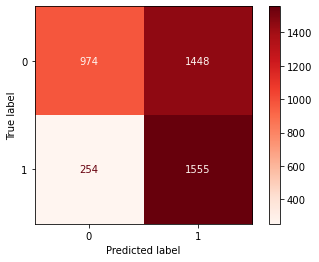

In [182]:
# Compute the confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline_rf_best, X_test, y_test, cmap = plt.cm.Reds)

- ROC curve

In [186]:
# Predict the class probabilities on the test set
y_test_pred_proba = pipeline_rf_best.predict_proba(X_test)[:, 1]
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
auc_score = roc_auc_score(y_test, y_test_pred_proba)
# Print the AUC score
print("AUC score:", auc_score)

AUC score: 0.6856158696379557


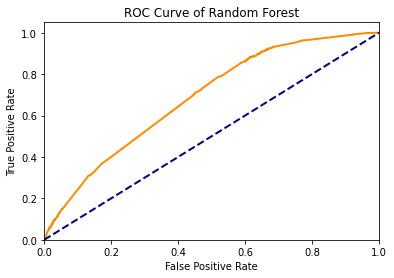

In [185]:
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of Random Forest")
plt.show()

#### Random Forest - Explanation on model performance
 - get top 20 important features
 - error analysis

**get top 20 important features**

In [295]:
## get the column names after one hot encoding
onehot_cols = pipeline_rf_best.named_steps['Preprocessor']\
                .named_transformers_['CategoricalEncoder']\
                .get_feature_names()
onehot_cols

array(['x0_advertisement', 'x0_blog', 'x0_campaign', 'x0_email',
       'x0_meeting', 'x0_news', 'x0_other', 'x0_radio', 'x0_social_media',
       'x0_speech', 'x0_statement', 'x0_television', 'x0_testimony'],
      dtype=object)

In [296]:
## get the column names after tf-idf vecterizer
text_vector_cols = pipeline_rf_best.named_steps['Preprocessor']\
                    .named_transformers_['TextVecterizer']\
                    .get_feature_names_out()
text_vector_cols

array(['00', '02', '04', ..., 'zoning', 'zoom', 'zuckerberg'],
      dtype=object)

In [297]:
feature_importance = pd.Series(data= pipeline_rf_best.named_steps['Classifier'].feature_importances_, 
                               index = np.array(num_cols + list(onehot_cols) + list(text_vector_cols)))

**Top 20 important features:**

In [298]:
feature_importance.sort_values(ascending=False)[:20]

x0_social_media     0.585522
x0_blog             0.148421
percent             0.085563
state               0.038826
biden               0.026220
americans           0.017681
statement_length    0.015514
half                0.005770
tax                 0.005403
spending            0.005191
since               0.004415
pay                 0.003917
today               0.003109
georgia             0.002692
republican          0.002170
nearly              0.002014
year                0.001976
three               0.001733
budget              0.001578
obama               0.001575
dtype: float64

The top 20 important feature result shows that:
- In terms of statement source: statements from social medial and blog are likely to preduce
- Statement length do have relationship with whether the statement is true
- In terms of statement content: keywords like 'percent','state', 'biden', 'tax', 'republican' are likely to indicate false statement

**Error Samples**

In [303]:
y_test_pred

array([1, 1, 1, ..., 0, 1, 1])

In [311]:
np.array(y_test['label'])

array([1, 0, 1, ..., 0, 1, 1])

In [364]:
error_index = y_test_pred != np.array(y_test['label'])
error_samples = pd.concat([X_test[error_index],y_test[error_index]],axis=1)
error_samples.head(8)

,statement_length,statement_source,clean_statement,label
18045,117,other,"Pat McCrory ""shepherded in driver’s licenses for illegal aliens in the aftermath of the 9/11 terrorist attacks.""",0
18426,91,blog,"Contrary to media reports, Georgia’s gas tax change led to no price increase at the pump.",1
9851,65,news,Social Security has not contributed to the debt and the deficits.,0
16835,94,social_media,How many federal rulings have NOW found intentional discrimination by #Txlege since 2011? 6.,1
18348,171,testimony,Only 20 percent of our current graduates from Texas high schools go ahead and achieve either a national certificate or a community college degree -- or a college degree.,0
15457,75,speech,"Barack Obama ""began his presidency going on a worldwide apology tour.""",0
13184,98,speech,The Iraq Study Group reported that (Saddam Hussein) had designs on reviving his nuclear program.,0
14057,81,campaign,No federal official at any level is currently allowed to say ‘Merry Christmas.’,0


**False Positive error samples**

In [406]:
## For this 5 samples, the model fails to predict them as false statment
FP_samples = X_features.iloc[[18045, 9851, 18348, 15457, 13184]]
FP_samples

,statement_length,statement_source,clean_statement
18045,117,other,"Pat McCrory ""shepherded in driver’s licenses for illegal aliens in the aftermath of the 9/11 terrorist attacks."""
9851,65,news,Social Security has not contributed to the debt and the deficits.
18348,171,testimony,Only 20 percent of our current graduates from Texas high schools go ahead and achieve either a national certificate or a community college degree -- or a college degree.
15457,75,speech,"Barack Obama ""began his presidency going on a worldwide apology tour."""
13184,98,speech,The Iraq Study Group reported that (Saddam Hussein) had designs on reviving his nuclear program.


In [427]:
for index, sample in FP_samples.iterrows():
    source = str(sample['statement_source'])
    print("source:"+str(feature_importance.loc["x0_"+source]))
    
    text = sample['clean_statement']
    string = ""
    for word in text.split(" "):
        word = word.lower()
        string += word 
        try:
            string += "(" + str(feature_importance.loc[word]) + ")"
        except:
            pass
        string += " "
    print(string)

source:0.0
pat(0.0) mccrory(0.0) "shepherded in driver’s licenses(0.0) for illegal(0.0) aliens(0.0) in the aftermath(0.0) of the 9/11 terrorist(0.0) attacks." 
source:0.0
social(0.0) security(0.0) has not contributed(0.0) to the debt(0.00014522846140332469) and the deficits. 
source:0.0
only 20(0.0) percent(0.08556263137317106) of our current(0.0) graduates(0.0) from texas(0.0) high(0.0) schools(0.0) go(8.223329941521533e-05) ahead(0.0) and achieve either(0.0) a national(0.0) certificate(0.0) or a community(0.0) college(0.0) degree(0.0) -- or a college(0.0) degree. 
source:0.0012485584909150726
barack(0.0) obama(0.0015745820063883937) "began his presidency(0.0) going(0.0) on a worldwide(0.0) apology tour." 
source:0.0012485584909150726
the iraq(0.0) study(0.0) group(0.0) reported(0.0) that (saddam hussein) had designs on reviving his nuclear(0.0) program. 


**Explanation:**
From the false Positive samples(model fails to predict them as false statment), we can see that the words in the sample statement are with low feature importance, and a lot are not existing in the features. That shows this kind of fake news may not exist in training set and thus the model didn;t get enough information.

This shows limition of information in training set.

**False Negative error samples**

In [429]:
## For this 2 samples, the model incorrectly predict them as false statment
FN_samples = X_features.iloc[[18426, 16835]]
FN_samples

,statement_length,statement_source,clean_statement
18426,91,blog,"Contrary to media reports, Georgia’s gas tax change led to no price increase at the pump."
16835,94,social_media,How many federal rulings have NOW found intentional discrimination by #Txlege since 2011? 6.


In [430]:
for index, sample in FN_samples.iterrows():
    source = str(sample['statement_source'])
    print("source:"+str(feature_importance.loc["x0_"+source]))
    
    text = sample['clean_statement']
    string = ""
    for word in text.split(" "):
        word = word.lower()
        string += word 
        try:
            string += "(" + str(feature_importance.loc[word]) + ")"
        except:
            pass
        string += " "
    print(string)

source:0.14842119396379996
contrary(0.0) to media(0.0) reports, georgia’s gas(0.0) tax(0.005403361285569143) change(0.00019080744932233705) led(0.0) to no price(0.0) increase(0.000334575131152208) at the pump. 
source:0.5855221015429528
how many(6.868434476110188e-05) federal(0.0002034159510943326) rulings(0.0) have now found(0.0) intentional discrimination(0.0) by #txlege since(0.004414566001314022) 2011? 6. 


**Explanation:**From the false negative samples(model incorrectly predict them as false statments), we can see that source counts for a lot. As the sources of these two samples are 'blog' and 'social_media', it will lead the model to give negative prediction. As these two features has large importance.

## XGBoost
 reference: https://arxiv.org/abs/1603.02754
 - Gradient Boosting Classifier is a machine learning algorithm that belongs to the class of gradient boosting models. It is an ensemble method that combines multiple weak learners, usually decision trees, to create a more powerful classifier.
 - The algorithm works by iteratively adding decision trees to the ensemble, with each tree learning to correct the errors made by the previous trees. During training, the algorithm starts with a single decision tree, and at each subsequent iteration, it adds a new tree that is trained on the errors of the previous trees. This process continues until a stopping criterion is met, such as reaching a maximum number of iterations or achieving a certain level of accuracy.
 - XGBoost is a more regularized form of Gradient Boosting. XGBoost uses advanced regularization (L1 & L2), which improves model generalization capabilities. XGBoost delivers high performance as compared to Gradient Boosting. Its training is very fast and can be parallelized across clusters.

#### XGBoost - build pipeline

In [436]:
pipeline_XGB = Pipeline([
    ("Preprocessor", preprocessor), 
    ("Classifier", XGBClassifier())
])

print out all the parameters i can tune in the pipeline

In [437]:
pipeline_XGB.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Preprocessor', 'Classifier', 'Preprocessor__n_jobs', 'Preprocessor__remainder', 'Preprocessor__sparse_threshold', 'Preprocessor__transformer_weights', 'Preprocessor__transformers', 'Preprocessor__verbose', 'Preprocessor__verbose_feature_names_out', 'Preprocessor__NumericalScaler', 'Preprocessor__CategoricalEncoder', 'Preprocessor__TextVecterizer', 'Preprocessor__NumericalScaler__clip', 'Preprocessor__NumericalScaler__copy', 'Preprocessor__NumericalScaler__feature_range', 'Preprocessor__CategoricalEncoder__categories', 'Preprocessor__CategoricalEncoder__drop', 'Preprocessor__CategoricalEncoder__dtype', 'Preprocessor__CategoricalEncoder__handle_unknown', 'Preprocessor__CategoricalEncoder__sparse', 'Preprocessor__TextVecterizer__analyzer', 'Preprocessor__TextVecterizer__binary', 'Preprocessor__TextVecterizer__decode_error', 'Preprocessor__TextVecterizer__dtype', 'Preprocessor__TextVecterizer__encoding', 'Preprocessor__TextVecterizer__input', 'Prep

#### XGBoost - Parameters choosen for tuning
- XGBClassifier()
 - **learning_rate**: the step size shrinkage used in each boosting iteration. A lower learning rate may result in better performance, but requires more iterations and longer training time.

 - **max_depth**: the maximum depth of each tree in the boosting process. Higher values can lead to overfitting, while lower values can lead to underfitting.

 - **n_estimators**: the number of boosting iterations to perform. Larger values can improve model performance, but also increase the risk of overfitting.

 - **subsample**: the fraction of observations to be randomly sampled for each tree. Smaller values can reduce variance and prevent overfitting, but may also increase bias.

 - **colsample_bytree**: the fraction of features to be randomly sampled for each tree. Similar to subsample, smaller values can reduce variance and prevent overfitting, but may also increase bias.

 - **gamma**: the minimum loss reduction required to make a split. Higher values can lead to more conservative tree growth and prevent overfitting, while lower values can lead to more aggressive tree growth and increase the risk of overfitting.

 - **reg_alpha**: the L1 regularization term on the weights. Higher values can lead to more sparsity and reduce overfitting, but may also increase bias.

 - **reg_lambda**: the L2 regularization term on the weights. Similar to reg_alpha, higher values can lead to more sparsity and reduce overfitting, but may also increase bias.

In [440]:
# Define the parameter dist to search over
XGB_param_dist = {
    'Preprocessor__TextVecterizer__max_df': [0.7, 0.8, 0.9],
    'Preprocessor__TextVecterizer__min_df': [3, 5, 10],
    'Preprocessor__TextVecterizer__ngram_range': [(1,1),(1,2),(2,2)],
    'Classifier__learning_rate': [0.1, 0.01, 0.001],
    'Classifier__max_depth': [3, 5, 7],
    'Classifier__n_estimators': [50, 100, 150, 200],
    'Classifier__subsample': [0.5, 0.7, 1.0],
    'Classifier__colsample_bytree': [0.5, 0.7, 1.0],
    'Classifier__gamma': [0, 0.1, 0.5, 1],
    'Classifier__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'Classifier__reg_lambda': [0, 0.01, 0.1, 1, 10],
}

#### XGBoost - Parameter Tuning: RandomizedSearchCV()

In [441]:
start = time.time()
random_search = RandomizedSearchCV(pipeline_XGB, param_distributions=XGB_param_dist, scoring = 'f1', random_state = 42)
random_search.fit(X_train, y_train)

end = time.time()
print(end-start) 

59.03115725517273


Best parameters after tuing

In [442]:
## print out the best parameters
print(random_search.best_params_)

{'Preprocessor__TextVecterizer__ngram_range': (1, 2), 'Preprocessor__TextVecterizer__min_df': 3, 'Preprocessor__TextVecterizer__max_df': 0.7, 'Classifier__subsample': 1.0, 'Classifier__reg_lambda': 0.1, 'Classifier__reg_alpha': 0, 'Classifier__n_estimators': 150, 'Classifier__max_depth': 5, 'Classifier__learning_rate': 0.001, 'Classifier__gamma': 0, 'Classifier__colsample_bytree': 1.0}


#### XGBoost - Model Validation

In [443]:
pipeline_XGB_best = random_search.best_estimator_

In [444]:
scores = cross_val_score(pipeline_XGB_best, X_train, y_train, cv=5, scoring='f1')
print(scores)

[0.66528926 0.6598778  0.66250624 0.66286281 0.66632783]


#### XGBoost - Model evaluation on test data
After getting the best model, here I use different methods to evaluate the best model performance on test data:
accuracy score, classifiction report, confusion matrics, roc_auc

In [445]:
## fit the classifier on the training data
pipeline_XGB_best.fit(X_train, y_train)

## make prediction on testing data
y_test_pred = pipeline_X_best.predict(X_test)
y_test_pred

array([1, 1, 1, ..., 0, 1, 1])

- Accuracy score: 0.5979673835972583

In [447]:
XGB_accuracy = accuracy_score(y_test, y_test_pred)
XGB_accuracy

0.5979673835972583

- Classifiction report

In [448]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.40      0.53      2422
           1       0.52      0.87      0.65      1809

    accuracy                           0.60      4231
   macro avg       0.66      0.63      0.59      4231
weighted avg       0.68      0.60      0.58      4231



- Confusion Matrix

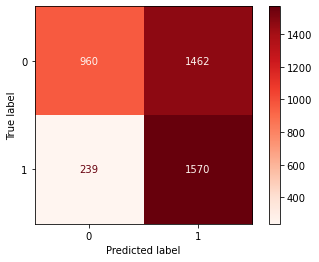

In [449]:
# Compute the confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline_XGB_best, X_test, y_test, cmap = plt.cm.Reds)

- ROC curve

In [450]:
# Predict the class probabilities on the test set
y_test_pred_proba = pipeline_XGB_best.predict_proba(X_test)[:, 1]
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
auc_score = roc_auc_score(y_test, y_test_pred_proba)
# Print the AUC score
print("AUC score:", auc_score)

AUC score: 0.6541525102261881


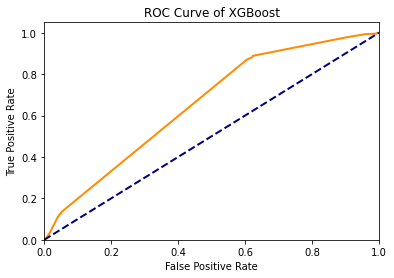

In [452]:
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of XGBoost")
plt.show()

#### XGBoost - Explanation on model performance
 - get top 20 important features
 - error analysis

**get top 20 important features**

In [455]:
## get the column names after tf-idf vecterizer
XGB_text_vector_cols = pipeline_XGB_best.named_steps['Preprocessor']\
                    .named_transformers_['TextVecterizer']\
                    .get_feature_names_out()
text_vector_cols

array(['00', '02', '04', ..., 'zoning', 'zoom', 'zuckerberg'],
      dtype=object)

In [457]:
XGB_feature_importance = pd.Series(data= pipeline_XGB_best.named_steps['Classifier'].feature_importances_, 
                               index = np.array(num_cols + list(onehot_cols) + list(XGB_text_vector_cols)))


**Top 20 important features:**

In [458]:
XGB_feature_importance.sort_values(ascending=False)[:20]

x0_social_media     0.564969
x0_blog             0.144261
percent             0.032484
state               0.030466
half                0.029345
today               0.028088
americans           0.024893
pay                 0.018413
shows               0.017858
biden               0.014967
tax                 0.009263
georgia             0.008894
cut                 0.008850
five                0.007435
statement_length    0.007098
spending            0.006426
getting             0.006259
house               0.006054
go                  0.005748
john                0.005748
dtype: float32

The top 20 important feature result shows that:
- Social medial and blog still takes a large account in prediction
- The importance of Statement length in XGBoost is less than that in random forest
- Incomparison to the outcome of random forest, new keywords like 'half','spending', 'house' are likely to indicate false statement

**Error Samples**

In [464]:
y_test_pred

array([1, 1, 1, ..., 0, 1, 1])

In [465]:
np.array(y_test['label'])

array([1, 0, 1, ..., 0, 1, 1])

In [478]:
error_index = y_test_pred != np.array(y_test['label'])
error_samples = pd.concat([X_test[error_index],y_test[error_index]],axis=1)
error_samples[66:71]

,statement_length,statement_source,clean_statement,label
1057,225,television,"One of the things I would immediately do … is bring back the warrior class -- Petraeus, McChrystal, Mattis, Keane, Flynn. ... Every one was retired early because they told President Obama things that he didn’t want to hear.",0
7950,127,news,"""There aren’t enough ballots in question to change the outcome"" of the Harris vs. McCready race in NC Congressional District 9.",0
15174,179,blog,"[A]t his current rate, President Obama will have added more debt to the United State of America by the end of his first term than each of the previous 43 presidents -- combined!",1
15479,187,meeting,"Rare is the president ""who is passed more legislation, who is done more things than what we have done, between the executive orders and the job-killing regulations that have been terminated.""",0
2756,73,news,"his political opponents ""brought 100,000 protesters into our state.""",0


**False Positive error samples**

In [479]:
## For this 5 samples, the model fails to predict them as false statment
FP_samples = X_features.iloc[[1057, 7950, 15479, 2756]]
FP_samples

,statement_length,statement_source,clean_statement
1057,225,television,"One of the things I would immediately do … is bring back the warrior class -- Petraeus, McChrystal, Mattis, Keane, Flynn. ... Every one was retired early because they told President Obama things that he didn’t want to hear."
7950,127,news,"""There aren’t enough ballots in question to change the outcome"" of the Harris vs. McCready race in NC Congressional District 9."
15479,187,meeting,"Rare is the president ""who is passed more legislation, who is done more things than what we have done, between the executive orders and the job-killing regulations that have been terminated."""
2756,73,news,"his political opponents ""brought 100,000 protesters into our state."""


In [480]:
for index, sample in FP_samples.iterrows():
    source = str(sample['statement_source'])
    print("source:"+str(feature_importance.loc["x0_"+source]))
    
    text = sample['clean_statement']
    string = ""
    for word in text.split(" "):
        word = word.lower()
        string += word 
        try:
            string += "(" + str(feature_importance.loc[word]) + ")"
        except:
            pass
        string += " "
    print(string)

source:0.0
one(0.0) of the things(0.0) i would immediately(0.0) do … is bring(0.0) back(0.0) the warrior class(0.0) -- petraeus, mcchrystal, mattis, keane, flynn. ... every(0.0) one(0.0) was retired(0.0) early(0.0) because they told(0.0) president(0.0037323448) obama(0.0) things(0.0) that he didn’t want(0.0) to hear. 
source:0.0
"there aren’t enough(0.0) ballots(0.0) in question(0.0) to change(0.0) the outcome" of the harris(0.0) vs. mccready(0.0) race(0.0) in nc congressional district(0.0) 9. 
source:0.0
rare(0.0) is the president(0.0037323448) "who is passed(0.0) more legislation, who is done(0.0) more things(0.0) than what we have done, between the executive(0.0) orders(0.0) and the job-killing regulations(0.0) that have been terminated." 
source:0.0
his political(0.0) opponents(0.0) "brought 100,000 protesters(0.0) into our state." 


**Explanation:**
Still the words in the sample statement are with low feature importance, and a lot are not existing in the features. That shows this kind of fake news may not exist in training set and thus the model didn't get enough information, which shows limition of information in training set.

## Neural Network using BERT pre-trained model

In [700]:
# Tokenizing all the sentences using pre-trained BERT model from Tranformers
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
    ids = []
    for sentence in sentences:
        encoding = tokenizer.encode_plus(
        sentence,
        max_length=16,
        truncation = True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=False)
        ids.append(encoding['input_ids'])
    return ids


train_ids = encoder(X_train)
test_ids = encoder(X_test) 

In [704]:
# convert arrays to tensors
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(y_test)
train_labels = tf.convert_to_tensor(y_train)

In [705]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [706]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 16)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             16, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

# Comparison of Model Performance
Use three matrics to compare the model performance
- accuracy: measures the overall correctness of the model's prediction
- f1_score: a weighted average of precision and recall. a measure of a model's accuracy that considers both precision and recall
- AUC_score: the area under the ROC curve. a measure of how well the model can distinguish between positive and negative classes.

In [696]:
df_comparison = pd.DataFrame({
    'model':['Naive Bayes','Random Forest','XGBoost'],
    'accuracy':[0.67, 0.60, 0.60],
    'f1_score_positive':[0.60, 0.52, 0.52],
    'f1_score_negative':[0.69, 0.53, 0.53],
    'AUC_socre': [0.74, 0.69, 0.60]
})

In [697]:
df_comparison

,model,accuracy,f1_score_positive,f1_score_negative,AUC_socre
0,Naive Bayes,0.67,0.60,0.69,0.74
1,Random Forest,0.60,0.52,0.53,0.69
2,XGBoost,0.60,0.52,0.53,0.60


# Conclusion

 - Overall, the Naive Bayes has the best performance on this classification task. The accuracy of Naive Bayes is 0.67, and the AUC score is 0.74. Both Random Forest and XGBoost perform worse on this dataset.
 - Naive Bayes works well for spam filtering because it is based on the idea that spam messages are more likely to contain certain words or patterns of words than legitimate messages. 
 - Random Forest and XGBoost are better at capturing complex feature interections, while naive bayes is assuming all features being independent. They may be better than Naive Bayes in the tasks when text context are important to capture